In [2]:
from station_data import *
from stream_processing import *
from event_detection import *
from catalogued_events import *
from stream_processing import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import torch
import sys
from report_generation import *
from email_sending import *

### This Notebook produces contents for report or email notification using previous saved files of data produced.

In [3]:
# %store -r date station

Initiating Parameters for Report Content Generation

In [4]:
# Set date and station for studying423
date = UTCDateTime("2024-04-23") 
station = ['AM','R50D6','https://data.raspberryshake.org']
station_coordinates = get_coordinates(station)

# Generate a path for all files to be saved to
date_folder = generate_data_path(date, station)
content_path = os.path.join(date_folder, "generated")
os.makedirs(content_path, exist_ok=True)

Reading Saved Files

In [5]:
saved_df_completed = read_csv_from_path(date_folder, date, station, 'completed')
saved_processed_stream = read_stream_from_path(date_folder, date, station, 'processed')
saved_annotated_stream = read_stream_from_path(date_folder, date, station, 'processed.annotated')

Loaded csv from D:\Dissertation\data\AM.R50D6\2024-04-23\2024-04-23.completed.csv
Loaded stream from D:\Dissertation\data\AM.R50D6\2024-04-23\2024-04-23_AM.R50D6..Z.processed.mseed
Loaded stream from D:\Dissertation\data\AM.R50D6\2024-04-23\2024-04-23_AM.R50D6..Z.processed.annotated.mseed


In [6]:
matched_events_df = extract_matched_events(saved_df_completed)

In [7]:
matched_events_df

,provider,event_id,time,lat,long,mag,mag_type,depth,epi_distance,P_predict,S_predict,catalogued,detected,P_detected,S_detected,S_peak_confidence,P_peak_confidence,P_error,S_error
0,IRIS,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-24T00:15:14.040000,19.1955,-67.410667,3.39,md,9970.0,6739.898025,2024-04-24T00:25:24.918537,2024-04-24T00:33:41.907555,True,True,NaN,2024-04-24T00:33:58.880000,0.749654,NaN,NaN,+16.97s
5,IRIS,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T16:02:21.083000,24.0676,121.692700,4.90,mb,6571.0,9743.508062,2024-04-23T16:15:10.138300,2024-04-23T16:25:52.739126,True,True,2024-04-23T16:15:18.970000,NaN,NaN,0.835722,+8.83s,NaN
7,IRIS,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T13:05:39.336000,50.0999,-28.970400,5.00,mww,9121.0,1921.274830,2024-04-23T13:09:42.848903,2024-04-23T13:13:21.000711,True,True,2024-04-23T13:09:48.950000,NaN,NaN,0.703402,+6.10s,NaN
19,IRIS,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T02:20:59.691000,23.8259,121.633300,5.20,mwr,10000.0,9764.020713,2024-04-23T02:33:49.058574,2024-04-23T02:44:32.124338,True,True,2024-04-23T02:33:40.040000,NaN,NaN,0.859432,-9.02s,NaN
27,IRIS,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:03:49.290000,23.6992,121.639100,4.50,mb,20652.0,9776.590332,2024-04-23T00:16:37.432461,2024-04-23T00:27:19.780646,True,True,2024-04-23T00:16:35.020000,NaN,NaN,0.798008,-2.41s,NaN


In [35]:
from obspy.geodetics import gps2dist_azimuth
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import numpy as np


from stream_processing import *
denoiser_model = sbm.DeepDenoiser.from_pretrained("original")

def clean_stream(stream):
    processed_stream = stream_process(stream)
    denoised_stream = deep_denoiser(processed_stream, denoiser_model)
    return denoised_stream

def create_time_window_from_row(p_detected_time, window_minutes=1):
    if pd.notna(p_detected_time):
        p_detected_utc = UTCDateTime(p_detected_time)
        
        # 创建时间窗口
        start_time = (p_detected_utc - (window_minutes * 60)).isoformat()  
        end_time = (p_detected_utc + (window_minutes * 60)).isoformat()  
    
        
        return start_time, end_time
    else:
        return None, None

def calculate_distance(station_coordinates, epicenter_coordinates):
    distance_meters, azimuth, back_azimuth = gps2dist_azimuth(
        station_coordinates[0], station_coordinates[1],  # Station latitude and longitude
        epicenter_coordinates[0], epicenter_coordinates[1]  # Epicenter latitude and longitude
    )
    distance_kilometers = distance_meters / 1000.0
    return distance_kilometers

def get_coordinates(station_information):
    try:
        if len(station_information) != 3:
            raise ValueError(
                "station_info list must contain exactly three elements: network, station, and service_url.")

        network, station, service_url = station_information

        # Create an instance of the FDSN client
        client = Client(service_url)

        # Get current time for the endtime to ensure the station metadata is up-to-date
        endtime = UTCDateTime()

        # Fetch station metadata
        inventory = client.get_stations(network=network, station=station, endtime=endtime, level='station')

        # Extract latitude and longitude from the inventory
        station_information = inventory[0][0]  # Assumes only one station matches the query
        latitude = station_information.latitude
        longitude = station_information.longitude
        return (latitude, longitude)
    except Exception as e:
        print(f"Error fetching station coordinates: {e}")
        return None

from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth

def get_nearby_stations_uniform(station_coordinates, step_size=0.3, num_steps=3, client_name='https://data.raspberryshake.org'):
    def generate_range(center, step_size, num_steps):
        return [center + step_size * i for i in range(1, num_steps + 1)] + \
               [center - step_size * i for i in range(1, num_steps + 1)]
    
    def calculate_distance(lat1, lon1, lat2, lon2):
        distance_meters, azimuth, back_azimuth = gps2dist_azimuth(lat1, lon1, lat2, lon2)
        distance_kilometers = distance_meters / 1000.0
        return distance_kilometers
    
    client = Client(client_name)
    latitude, longitude = station_coordinates
    
    lat_range = generate_range(latitude, step_size, num_steps)
    lon_range = generate_range(longitude, step_size, num_steps)

    try:
        inventory = client.get_stations(minlatitude=min(lat_range), maxlatitude=max(lat_range),
                                        minlongitude=min(lon_range), maxlongitude=max(lon_range))
    except Exception as e:
        print(f"Error fetching stations: {e}")
        return []

    stations = []
    for network in inventory:
        for station in network:
            dist_km = calculate_distance(latitude, longitude, station.latitude, station.longitude)
            stations.append({
                "network": network.code,
                "station": station.code,
                "coordinates": (station.latitude, station.longitude),
                "distance_to_main": dist_km
            })

    selected_stations = []
    for lat_diff in [step_size * i for i in range(1, num_steps + 1)]:
        for lon_diff in [step_size * i for i in range(1, num_steps + 1)]:
            for station in stations:
                lat_diff_actual = abs(station['coordinates'][0] - latitude)
                lon_diff_actual = abs(station['coordinates'][1] - longitude)
                if (lat_diff_actual >= lat_diff - 0.05 and lat_diff_actual <= lat_diff + 0.05) and \
                   (lon_diff_actual >= lon_diff - 0.05 and lon_diff_actual <= lon_diff + 0.05):
                    selected_stations.append(station)
                    break

    #if len(selected_stations) > 20:
     #   selected_stations = selected_stations[:20]
    
    return [[station['network'], station['station'], client_name] for station in selected_stations]

def download_stream_from_window(time_window, station_information):
    start_time, end_time = time_window
    network, station, data_provider = station_information
    location = "*"
    channel = "*Z*"
    
    client = Client(data_provider)
    
    try:
        print(f"Fetching data for {network}.{station} from {start_time} to {end_time}")
        st = client.get_waveforms(network, station, location, channel,
                                  UTCDateTime(start_time), UTCDateTime(end_time),
                                  attach_response=True)
        st.merge()
        for tr in st:
            if isinstance(tr.data, np.ma.masked_array):
                tr.data = tr.data.filled()
        print(f"Data from {start_time} to {end_time} downloaded successfully.")
        return st
    except FDSNNoDataException:
        print(f"No data available from {start_time} to {end_time}.")
        return None
    except Exception as e:
        if "429" in str(e) or "502" in str(e) or "rate limit" in str(e).lower():
            print("Rate limit exceeded, waiting for 60 seconds.")
            time.sleep(60)
            return download_stream_from_window(time_window, station_information)
        else:
            print(f"An error occurred from {start_time} to {end_time}: {str(e)}")
            return None

In [44]:
for _, row in matched_events_df.iterrows():
    event_details = get_event_info(row)  
    time_window = create_time_window_from_row(event_details.get('detected_p_time'), window_minutes=1)
    event_coordinates = (event_details.get('lat'), event_details.get('long'))
    print(time_window)
    print(event_coordinates)


(None, None)
(19.1955, -67.410667)
('2024-04-23T16:14:18.970000', '2024-04-23T16:16:18.970000')
(24.0676, 121.6927)
('2024-04-23T13:08:48.950000', '2024-04-23T13:10:48.950000')
(50.0999, -28.9704)
('2024-04-23T02:32:40.040000', '2024-04-23T02:34:40.040000')
(23.8259, 121.6333)
('2024-04-23T00:15:35.020000', '2024-04-23T00:17:35.020000')
(23.6992, 121.6391)


In [42]:
nearby_stations = get_nearby_stations_uniform(station_coordinates, step_size=0.5, num_steps=10)
nearby_stations

[['AM', 'RFC41', 'https://data.raspberryshake.org'],
 ['AM', 'R700A', 'https://data.raspberryshake.org'],
 ['AM', 'R4F51', 'https://data.raspberryshake.org'],
 ['AM', 'S29AB', 'https://data.raspberryshake.org'],
 ['AM', 'RFCA8', 'https://data.raspberryshake.org'],
 ['AM', 'R9098', 'https://data.raspberryshake.org'],
 ['AM', 'R1EA5', 'https://data.raspberryshake.org'],
 ['AM', 'REE67', 'https://data.raspberryshake.org'],
 ['AM', 'RAC94', 'https://data.raspberryshake.org'],
 ['AM', 'RB27C', 'https://data.raspberryshake.org'],
 ['AM', 'R7DC3', 'https://data.raspberryshake.org']]

Fetching data for AM.RFC41 from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000
No data available from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000.
Fetching data for AM.R700A from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000
No data available from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000.
Fetching data for AM.R4F51 from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000
No data available from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000.
Fetching data for AM.S29AB from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000
No data available from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000.
Fetching data for AM.RFCA8 from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000
Data from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000 downloaded successfully.
CUDA available. Running on GPU
Fetching data for AM.R9098 from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000
No data available f

C:\Users\isola\anaconda3\envs\gputest\Lib\site-packages\obspy\signal\filter.py:62: UserWarning: Selected high corner frequency (40) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


CUDA available. Running on GPU
Fetching data for AM.RB27C from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000
No data available from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000.
Fetching data for AM.R7DC3 from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000
No data available from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000.
Fetching data for AM.R50D6 from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000
Data from 2024-04-23T02:32:40.040000 to 2024-04-23T02:34:40.040000 downloaded successfully.
CUDA available. Running on GPU


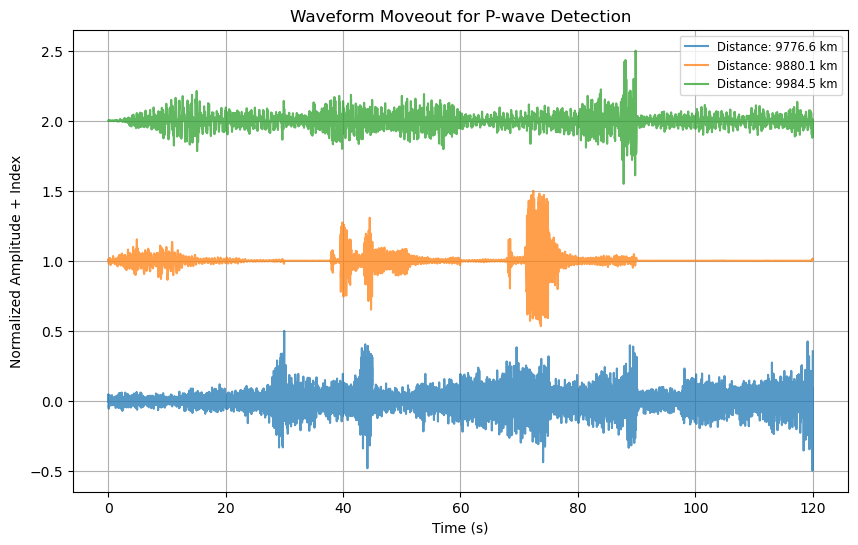

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 streams 和 distances 已初始化为空列表
streams = []
distances = []

# 定义时间窗口和事件的坐标
time_window = ('2024-04-23T02:32:40.040000', '2024-04-23T02:34:40.040000')
event_coordinates = (23.6992, 121.6391)

# 定义主站台信息
main_station = ['AM', 'R50D6', 'https://data.raspberryshake.org']
main_station_coordinates = get_coordinates(main_station)

# 处理每个站台的信息
for station_info in nearby_stations:
    stream = download_stream_from_window(time_window, station_info)
    
    if stream:
        station_coordinates = get_coordinates(station_info)
        distance = calculate_distance(station_coordinates, event_coordinates)
        
        new = clean_stream(stream)
        streams.append(new)
        distances.append(distance)

# 单独处理主站台的数据
main_stream = download_stream_from_window(time_window, main_station)
if main_stream:
    main_stream_cleaned = clean_stream(main_stream)
    main_distance = calculate_distance(main_station_coordinates, event_coordinates)
    streams.append(main_stream_cleaned)
    distances.append(main_distance)

# 绘制所有的 stream 在一张图上
fig, ax = plt.subplots(figsize=(10, 6))
offset = 1  # 设置每个波形之间的固定偏移量

# 对 streams 和 distances 按距离进行排序
sorted_streams_distances = sorted(zip(streams, distances), key=lambda x: x[1])

# 确保每个波形不会超过 offset 的一半以避免重叠
for i, (stream, distance) in enumerate(sorted_streams_distances):
    tr = stream[0]
    times = tr.times()
    normalized_data = tr.data / np.max(np.abs(tr.data))  # 归一化
    ax.plot(times, normalized_data * (offset / 2) + i * offset, label=f'Distance: {distance:.1f} km', alpha=0.75)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized Amplitude + Index')
ax.set_title('Waveform Moveout for P-wave Detection')
ax.legend(loc='upper right', fontsize='small')
plt.grid()
plt.show()
